<a href="https://colab.research.google.com/github/yoshithavalluru/assignment-1/blob/main/VPG_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Name: Yoshitha Valluru

ID: 1002029854



In [5]:
!pip install gymnasium==0.27.1 -q
!pip install gymnasium[box2d] -q
!pip install moviepy -q
!pip install -U kora -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 77.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368
  

In [6]:
import random
import numpy as np
import torch.cuda
import torch


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'



def apply_reward_to_go(raw_reward):
    # Reverse the list of rewards
    raw_reward = raw_reward[::-1]

    # Calculate the running sum of rewards
    running_sum = 0
    rtg_rewards = []
    for r in raw_reward:
        running_sum = r + running_sum
        rtg_rewards.append(running_sum)

    # Reverse the rtg_rewards list again to match the order of the original list
    rtg_rewards = rtg_rewards[::-1]

    # Normalize the rewards
    rtg_rewards = np.array(rtg_rewards)
    rtg_rewards = (rtg_rewards - np.mean(rtg_rewards)) / (np.std(rtg_rewards) + np.finfo(np.float32).eps)

    # Convert the rtg_rewards to a PyTorch tensor and return
    return torch.tensor(rtg_rewards, dtype=torch.float32, device=get_device())


def apply_discount(raw_reward, gamma=0.99):
    # Reverse the list of rewards
    raw_reward = raw_reward[::-1]

    # Calculate the discounted reward
    running_sum = 0
    discounted_rtg_reward = []
    for r in raw_reward:
        running_sum = r + gamma * running_sum
        discounted_rtg_reward.append(running_sum)

    # Reverse the discounted_rtg_reward list again to match the order of the original list
    discounted_rtg_reward = discounted_rtg_reward[::-1]

    # Normalize the rewards
    discounted_rtg_reward = np.array(discounted_rtg_reward)
    discounted_rtg_reward = (discounted_rtg_reward - np.mean(discounted_rtg_reward)) / (np.std(discounted_rtg_reward) + np.finfo(np.float32).eps)

    # Convert the discounted_rtg_reward to a PyTorch tensor and return
    return torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device())




# Util function to apply reward-return (cumulative reward) on a list of instant-reward (from eq 6)
def apply_return(raw_reward):
    # Compute r_reward (as a list) from raw_reward
    r_reward = [np.sum(raw_reward) for _ in raw_reward]
    return torch.tensor(r_reward, dtype=torch.float32, device=get_device())

In [7]:
import pickle
import gymnasium as gym
import torch
from gymnasium.utils.save_video import save_video
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical


class PGTrainer:
    def __init__(self, params):
        self.params = params
        self.env = gym.make(self.params['env_name'])
        self.agent = Agent(env=self.env, params=self.params)
        self.actor_policy = PGPolicy(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.optimizer = Adam(params=self.actor_policy.parameters(), lr=self.params['lr'])

    def run_training_loop(self):
        list_ro_reward = list()

        for ro_idx in range(self.params['n_rollout']):
            trajectory = self.agent.collect_trajectory(policy=self.actor_policy)
            loss = self.estimate_loss_function(trajectory)
            self.update_policy(loss)
            # Calculate the average reward for each trajectory
      
            total_ro_reward = 0
            ntr = self.params['n_trajectory_per_rollout']
            for tr_idx in range(ntr):
                start_idx = tr_idx * self.params['n_rollout']
                end_idx = start_idx + self.params['n_rollout']
                total_ro_reward += sum([sum(r) for r in trajectory['reward'][start_idx:end_idx]])

            avg_ro_reward = total_ro_reward / ntr
            print(f'End of rollout {ro_idx}: Average trajectory reward is {avg_ro_reward: 0.2f}')
            # Append average rollout reward into a list
            list_ro_reward.append(avg_ro_reward)
        # Save avg-rewards as pickle files
        pkl_file_name = self.params['exp_name'] + '.pkl'
        with open(pkl_file_name, 'wb') as f:
            pickle.dump(list_ro_reward, f)
        # Save a video of the trained agent playing
        self.generate_video()
        # Close environment
        self.env.close()

    
    def estimate_loss_function(self, trajectory):
        loss = []
        for traj_idx in range(self.params['n_trajectory_per_rollout']):
        # Get the rewards for the current trajectory
            reward = torch.tensor(trajectory['reward'][traj_idx], dtype=torch.float32)
        
        # Get the log-probs for the current trajectory
            log_prob = trajectory['log_prob'][traj_idx]
        
        # Compute the loss based on the flags
            if self.params['reward_to_go'] and self.params['reward_discount']:
                rtg_reward = apply_reward_to_go(reward.tolist)
                discounted_reward = apply_discount(reward.tolist())
                rtg_discounted_reward = apply_discount(rtg_reward)
                loss.append(-1 * (rtg_discounted_reward * log_prob).mean())
            elif self.params['reward_to_go']:
                rtg_reward = apply_reward_to_go(reward.tolist())
                loss.append(-1 * (rtg_reward * log_prob).mean())
            elif self.params['reward_discount']:
                discounted_reward = apply_discount(reward.tolist())
                loss.append(-1 * (discounted_reward * log_prob).mean())
            else:
                r_reward = apply_return(reward.tolist())
                loss.append(-1 * (r_reward * log_prob).mean())  
        loss = torch.stack(loss).mean()
        return loss




    def update_policy(self, loss):
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def generate_video(self, max_frame=1000):
        env_name = self.params['env_name']
        exp_name = self.params['exp_name']
        self.env = gym.make(env_name, render_mode='rgb_array_list')
        obs, _ = self.env.reset()
        for _ in range(max_frame):
            action_idx, log_prob = self.actor_policy(torch.tensor(obs, dtype=torch.float32, device=get_device()))
            obs, reward, terminated, truncated, info = self.env.step(self.agent.action_space[action_idx.item()])
            if terminated or truncated:
                break
        video_name = f"{exp_name}_{env_name[:-3]}"
        save_video(frames=self.env.render(), video_folder=video_name, fps=self.env.metadata['render_fps'], step_starting_index=0, episode_index=0)
        self.env.close()

class PGPolicy(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(PGPolicy, self).__init__()
        # Define the policy net
        self.policy_net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        # Forward pass of policy net
        policy_dist = Categorical(self.policy_net(obs))
        action_index = policy_dist.sample()
        log_prob = policy_dist.log_prob(action_index)
        return action_index, log_prob


class Agent:
    def __init__(self, env, params=None):
        self.env = env
        self.params = params
        self.action_space = [action for action in range(self.env.action_space.n)]

    def collect_trajectory(self, policy):
        obs, _ = self.env.reset(seed=self.params['rng_seed'])
        rollout_buffer = list()
        for _ in range(self.params['n_trajectory_per_rollout']):
            trajectory_buffer = {'log_prob': list(), 'reward': list()}
            while True:
                # Get action from the policy (forward pass of policy net)
                action_idx, log_prob = policy.forward(torch.from_numpy(obs).float())
                obs, reward, terminated, truncated, info = self.env.step(self.action_space[action_idx.item()])
                # Save log-prob and reward into the buffer
                trajectory_buffer['log_prob'].append(log_prob)
                trajectory_buffer['reward'].append(reward)
                # Check for termination criteria
                if terminated or truncated:
                    obs, _ = self.env.reset(seed=self.params['rng_seed'])
                    rollout_buffer.append(trajectory_buffer)
                    break
        rollout_buffer = self.serialize_trajectory(rollout_buffer)
        return rollout_buffer

    # Converts a list-of-dictionary into dictionary-of-list
    @staticmethod
    def serialize_trajectory(rollout_buffer):
        serialized_buffer = {'log_prob': list(), 'reward': list()}
        for trajectory_buffer in rollout_buffer:
            serialized_buffer['log_prob'].append(torch.stack(trajectory_buffer['log_prob']))
            serialized_buffer['reward'].append(trajectory_buffer['reward'])
        return serialized_buffer

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')
%cd ADV AI
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/ADV AI
CartPole_v1_t0_CartPole  LunarLander-v2_t0_LunarLander
CartPole_v1_t0.pkl	 LunarLander-v2_t0.pkl
CartPole_v1_t1_CartPole  LunarLander-v2_t1_LunarLander
CartPole_v1_t1.pkl	 LunarLander-v2_t1.pkl
CartPole_v1_t2_CartPole  LunarLander-v2_t2_LunarLander
CartPole_v1_t2.pkl	 LunarLander-v2_t2.pkl


In [8]:
# Define four sets of parameters
params_list = [
    {
        'env_name': 'CartPole-v1',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': False,
        'n_rollout': 100,
        'n_trajectory_per_rollout': 10,
        'hidden_dim': 64,
        'lr': 3e-3,
        'exp_name': 'CartPole_v1_t0'
    },
    {
        'env_name': 'CartPole-v1',
        'rng_seed': 6369,
        'reward_to_go': True,
        'reward_discount': False,
        'n_rollout': 100,
        'n_trajectory_per_rollout': 10,
        'hidden_dim': 64,
        'lr': 3e-3,
        'exp_name': 'CartPole_v1_t1'
    },
    {
        'env_name': 'CartPole-v1',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,
        'n_rollout': 100,
        'n_trajectory_per_rollout': 10,
        'hidden_dim': 64,
        'lr': 3e-3,
        'exp_name': 'CartPole_v1_t2'
    }
]

# Train agent with each set of parameters
for params in params_list:
  # Seed RNGs
    seed_everything(params['rng_seed'])

    # Train agent
    trainer = PGTrainer(params)
    trainer.run_training_loop()


End of rollout 0: Average trajectory reward is  21.20
End of rollout 1: Average trajectory reward is  17.80
End of rollout 2: Average trajectory reward is  23.70
End of rollout 3: Average trajectory reward is  22.80
End of rollout 4: Average trajectory reward is  13.80
End of rollout 5: Average trajectory reward is  18.90
End of rollout 6: Average trajectory reward is  18.70
End of rollout 7: Average trajectory reward is  22.20
End of rollout 8: Average trajectory reward is  31.30
End of rollout 9: Average trajectory reward is  14.60
End of rollout 10: Average trajectory reward is  22.20
End of rollout 11: Average trajectory reward is  27.80
End of rollout 12: Average trajectory reward is  19.30
End of rollout 13: Average trajectory reward is  25.70
End of rollout 14: Average trajectory reward is  26.90
End of rollout 15: Average trajectory reward is  19.40
End of rollout 16: Average trajectory reward is  23.30
End of rollout 17: Average trajectory reward is  19.30
End of rollout 18: A

Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/ADV AI/CartPole_v1_t0_CartPole/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  21.20
End of rollout 1: Average trajectory reward is  23.60
End of rollout 2: Average trajectory reward is  18.90
End of rollout 3: Average trajectory reward is  16.40
End of rollout 4: Average trajectory reward is  19.20
End of rollout 5: Average trajectory reward is  19.20
End of rollout 6: Average trajectory reward is  17.70
End of rollout 7: Average trajectory reward is  15.50
End of rollout 8: Average trajectory reward is  27.80
End of rollout 9: Average trajectory reward is  24.50
End of rollout 10: Average trajectory reward is  23.30
End of rollout 11: Average trajectory reward is  15.70
End of rollout 12: Average trajectory reward is  22.60
End of rollout 13: Average trajectory reward is  22.50
End of rollout 14: Average trajectory reward is  28.00
End of rollout 15: Average trajectory reward is  23.10
End of rollou

Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/ADV AI/CartPole_v1_t1_CartPole/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  21.20
End of rollout 1: Average trajectory reward is  23.60
End of rollout 2: Average trajectory reward is  20.20
End of rollout 3: Average trajectory reward is  15.80
End of rollout 4: Average trajectory reward is  18.50
End of rollout 5: Average trajectory reward is  19.20
End of rollout 6: Average trajectory reward is  17.70
End of rollout 7: Average trajectory reward is  15.50
End of rollout 8: Average trajectory reward is  24.50
End of rollout 9: Average trajectory reward is  20.10
End of rollout 10: Average trajectory reward is  17.70
End of rollout 11: Average trajectory reward is  21.80
End of rollout 12: Average trajectory reward is  22.50
End of rollout 13: Average trajectory reward is  19.40
End of rollout 14: Average trajectory reward is  32.20
End of rollout 15: Average trajectory reward is  29.00
End of rollou

Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/ADV AI/CartPole_v1_t2_CartPole/rl-video-episode-0.mp4


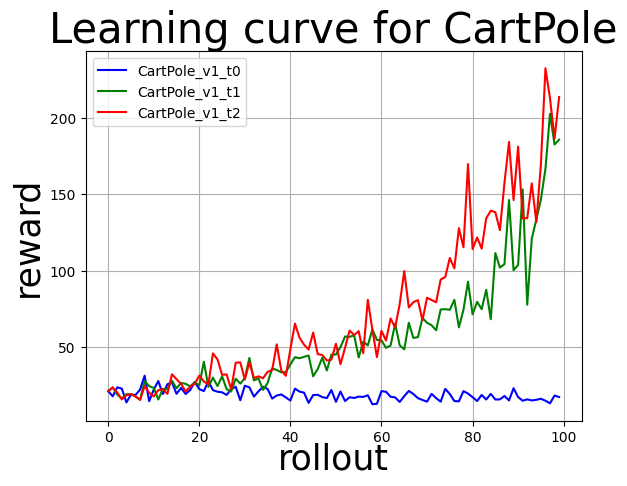

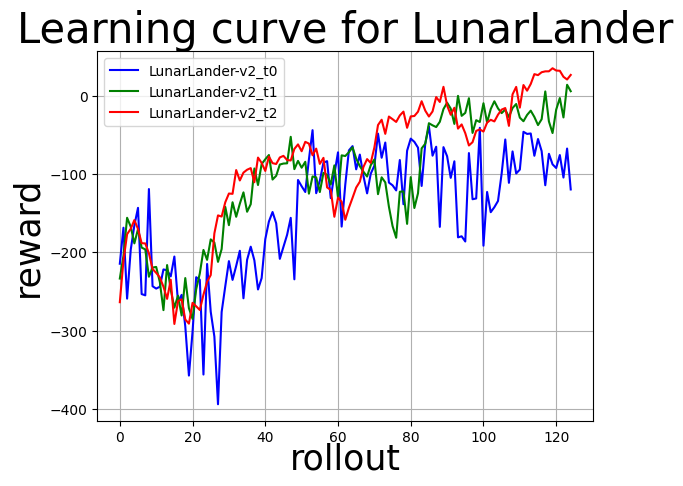

In [10]:
import argparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load rewards data for each experiment
exp_names = ['CartPole_v1_t0', 'CartPole_v1_t1', 'CartPole_v1_t2']
colors = ['blue', 'green', 'red']
exp_rewards = []
for name in exp_names:
    with open(name+'.pkl', 'rb') as f:
        exp_rewards.append(pickle.load(f))

# Plot the data
for i in range(len(exp_rewards)):
    sns.lineplot(data=exp_rewards[i], color=colors[i], label=exp_names[i])
plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for CartPole', fontsize=30)
plt.legend()
plt.grid()
plt.show()


exp_names = ['LunarLander-v2_t0', 'LunarLander-v2_t1', 'LunarLander-v2_t2']
colors = ['blue', 'green', 'red']
exp_rewards = []

for name in exp_names:
    with open(name+'.pkl', 'rb') as f:
        exp_rewards.append(pickle.load(f))

# Plot the data
for i in range(len(exp_rewards)):
    sns.lineplot(data=exp_rewards[i], color=colors[i], label=exp_names[i])
plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for LunarLander', fontsize=30)
plt.legend()
plt.grid()
plt.show()


In [ ]:
exp_names = ['LunarLander-v2_t0', 'LunarLander-v2_t1', 'LunarLander-v2_t2']
colors = ['blue', 'green', 'red']
exp_rewards = []
exp_rewards_mean = []
exp_rewards_var = []
for name in exp_names:
    with open(name+'.pkl', 'rb') as f:
        rewards = pickle.load(f)
        exp_rewards.append(rewards)
        exp_rewards_mean.append(np.mean(rewards, axis=0))
        exp_rewards_var.append(np.var(rewards, axis=0))


print(exp_rewards_mean)
print(exp_rewards_var)


[-113.8463673333154, -65.90700262221598, 41.90412405877437]
[14933.923710462645, 15479.176796960233, 31354.333243596426]


In [9]:
params_list = [
    {
        'env_name': 'LunarLander-v2',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,
        'n_rollout': 125,
        'n_trajectory_per_rollout': 5,
        'hidden_dim': 128,
        'lr': 3e-3,
        'exp_name': 'LunarLander-v2_t0'
    },
     {
        'env_name': 'LunarLander-v2',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,
        'n_rollout': 125,
        'n_trajectory_per_rollout': 20,
        'hidden_dim': 128,
        'lr': 3e-3,
        'exp_name': 'LunarLander-v2_t1'
    },
      {
        'env_name': 'LunarLander-v2',
        'rng_seed': 6369,
        'reward_to_go': False,
        'reward_discount': True,'n_rollout': 125,
        'n_trajectory_per_rollout': 60,
        'hidden_dim': 128,
        'lr': 3e-3,
        'exp_name': 'LunarLander-v2_t2'
    },
]

# Train agent with each set of parameters
for params in params_list:
    # Seed RNGs
    seed_everything(params['rng_seed'])

    # Train agent
    trainer = PGTrainer(params)
    trainer.run_training_loop()

End of rollout 0: Average trajectory reward is -214.68
End of rollout 1: Average trajectory reward is -168.71
End of rollout 2: Average trajectory reward is -259.22
End of rollout 3: Average trajectory reward is -196.78
End of rollout 4: Average trajectory reward is -165.63
End of rollout 5: Average trajectory reward is -143.38
End of rollout 6: Average trajectory reward is -253.40
End of rollout 7: Average trajectory reward is -255.01
End of rollout 8: Average trajectory reward is -119.37
End of rollout 9: Average trajectory reward is -243.36
End of rollout 10: Average trajectory reward is -246.41
End of rollout 11: Average trajectory reward is -244.07
End of rollout 12: Average trajectory reward is -221.96
End of rollout 13: Average trajectory reward is -223.02
End of rollout 14: Average trajectory reward is -230.85
End of rollout 15: Average trajectory reward is -205.51
End of rollout 16: Average trajectory reward is -263.42
End of rollout 17: Average trajectory reward is -254.40
En

Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/ADV AI/LunarLander-v2_t0_LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is -233.60
End of rollout 1: Average trajectory reward is -204.62
End of rollout 2: Average trajectory reward is -156.05
End of rollout 3: Average trajectory reward is -167.40
End of rollout 4: Average trajectory reward is -188.71
End of rollout 5: Average trajectory reward is -170.41
End of rollout 6: Average trajectory reward is -194.05
End of rollout 7: Average trajectory reward is -196.39
End of rollout 8: Average trajectory reward is -231.28
End of rollout 9: Average trajectory reward is -219.57
End of rollout 10: Average trajectory reward is -218.78
End of rollout 11: Average trajectory reward is -238.03
End of rollout 12: Average trajectory reward is -273.90
End of rollout 13: Average trajectory reward is -216.38
End of rollout 14: Average trajectory reward is -247.78
End of rollout 15: Average trajectory reward is

Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/ADV AI/LunarLander-v2_t1_LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is -263.77
End of rollout 1: Average trajectory reward is -210.61
End of rollout 2: Average trajectory reward is -176.98
End of rollout 3: Average trajectory reward is -170.12
End of rollout 4: Average trajectory reward is -158.98
End of rollout 5: Average trajectory reward is -170.32
End of rollout 6: Average trajectory reward is -188.46
End of rollout 7: Average trajectory reward is -188.78
End of rollout 8: Average trajectory reward is -201.30
End of rollout 9: Average trajectory reward is -221.41
End of rollout 10: Average trajectory reward is -226.36
End of rollout 11: Average trajectory reward is -232.10
End of rollout 12: Average trajectory reward is -244.03
End of rollout 13: Average trajectory reward is -259.53
End of rollout 14: Average trajectory reward is -235.11
End of rollout 15: Average trajectory reward is

Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/ADV AI/LunarLander-v2_t2_LunarLander/rl-video-episode-0.mp4
